In [1]:
import wfdb
import csv
import pandas as pd
import numpy as np
import os

In [2]:
import os
import csv
import pandas as pd
import wfdb  # Make sure wfdb is installed

output_dir = "data_creation"
os.makedirs(output_dir, exist_ok=True)

# Patient numbers
patient_numbers = [
    "100", "101", "102", "103", "104", "105", "106", "107", "108", "109",
    "111", "112", "113", "114", "115", "116", "117", "118", "119", "121",
    "122", "123", "124", "200", "201", "202", "203", "205", "207", "208",
    "209", "210", "212", "213", "214", "215", "217", "219", "220", "221",
    "222", "223", "228", "230", "231", "232", "233", "234"
]

# N = normal 
# S = supra-ventricular premature
# V = ventricular escape
# F = fusion of ventricular and normal
# Q = unclassified heartbeats
symbol_to_category = {
    'N': 'N', '.': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'a': 'S', 'A': 'S', 'J': 'S', 'S': 'S',
    'V': 'V', 'E': 'V',
    'F': 'F',
    '/': 'Q', 'f': 'Q', 'Q': 'Q'
}

for patient_number in patient_numbers:
    try:
        # ECG data
        path_to_record = f"mit-database/{patient_number}"
        patient_record = wfdb.rdrecord(path_to_record)
        leads = patient_record.sig_name
        ecg_data = patient_record.p_signal

        # ECG CSV
        ecg_filename = f"{output_dir}/{patient_number}_ECG.csv"
        with open(ecg_filename, "w", newline='') as outfile:
            out_csv = csv.writer(outfile)
            out_csv.writerow(leads)
            for row in ecg_data:
                out_csv.writerow(row)

        # Annotations data
        annotation = wfdb.rdann(path_to_record, 'atr')
        symbols = annotation.symbol
        annotations = annotation.sample

        # Filter out symbols not in symbol_to_category
        filtered_symbols_annotations = [(sym, ann) for sym, ann in zip(symbols, annotations) if sym in symbol_to_category]
        categories = [symbol_to_category[sym] for sym, ann in filtered_symbols_annotations]
        annotations_filtered = [ann for sym, ann in filtered_symbols_annotations]

        df_annotations = pd.DataFrame({'Category': categories, 'Annotation': annotations_filtered})

        # Annotations CSV
        annotations_filename = f"{output_dir}/{patient_number}_Annotations.csv"
        df_annotations.to_csv(annotations_filename, index=False)

    except Exception as e:
        print(f"Failed to process: {patient_number}: {e}")

print("Done")

Done


In [3]:
import os
import pandas as pd
import numpy as np


def process_patient_data(patient_number, data_creation_dir="data_creation"):
    ecg_file_path = os.path.join(data_creation_dir, f"{patient_number}_ECG.csv")
    annotations_file_path = os.path.join(data_creation_dir, f"{patient_number}_Annotations.csv")
    
    patient_X = []
    patient_Y = []
    
    try:
        ecg_df = pd.read_csv(ecg_file_path)
        annotations_df = pd.read_csv(annotations_file_path)
    except FileNotFoundError:
        print(f"Files for patient {patient_number} not found. Skipping...")
        return [], []
    
    first_column_name = ecg_df.columns[0]
    second_column_name = ecg_df.columns[1] if len(ecg_df.columns) > 1 else None

    sampling_rate = 360  # Hz
    total_window_size_seconds = 1  # Total window size in seconds
    total_window_size_samples = total_window_size_seconds * sampling_rate

    for _, row in annotations_df.iterrows():
        annotation_point = row['Annotation']
        category = row['Category']
        
        # Randomly determine the window split around the annotation point
        before_seconds = np.random.uniform(0, total_window_size_seconds)
        after_seconds = total_window_size_seconds - before_seconds
        before_samples = int(before_seconds * sampling_rate)
        after_samples = int(after_seconds * sampling_rate)
        
        start_point = max(0, annotation_point - before_samples)
        end_point = start_point + total_window_size_samples  # Ensure the window is of the exact expected size
        
        # Adjust the end point if it exceeds the length of the data
        if end_point > len(ecg_df):
            end_point = len(ecg_df)
            start_point = max(0, end_point - total_window_size_samples)  # Adjust start point accordingly
        
        # Process data from the first column
        window_data_first_column = ecg_df.iloc[start_point:end_point][first_column_name].to_numpy()
        
        patient_X.append(window_data_first_column)
        patient_Y.append(category)
        
        # If there's a second column, process it and add as a new entry
        if second_column_name:
            window_data_second_column = ecg_df.iloc[start_point:end_point][second_column_name].to_numpy()
            
            patient_X.append(window_data_second_column)
            patient_Y.append(category)  # Repeat category for the new entry
    
    return patient_X, patient_Y



# Initialize lists to hold the entire dataset
all_X = []
all_Y = []

data_creation_dir = "data_creation"

# Process each patient
for patient_number in patient_numbers:
    patient_X, patient_Y = process_patient_data(patient_number, data_creation_dir)
    all_X.extend(patient_X)
    all_Y.extend(patient_Y)

X = np.array(all_X)
Y = np.array(all_Y)

In [4]:
X

array([[-0.145, -0.145, -0.145, ...,  0.   ,  0.   ,  0.   ],
       [-0.065, -0.065, -0.065, ...,  0.   ,  0.   ,  0.   ],
       [-0.145, -0.145, -0.145, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.02 ,  0.04 ,  0.045, ...,  0.   ,  0.   ,  0.   ],
       [-0.28 , -0.27 , -0.275, ...,  0.   ,  0.   ,  0.   ],
       [ 0.05 ,  0.08 ,  0.1  , ...,  0.   ,  0.   ,  0.   ]])

In [5]:
Y

array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype='<U1')

In [6]:
df_x = pd.DataFrame(X)
df_x

,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.080,-0.080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.080,-0.080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218983,0.130,0.125,0.100,0.080,0.070,0.060,0.060,0.075,0.100,0.090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
218984,-0.340,-0.340,-0.340,-0.350,-0.365,-0.365,-0.360,-0.350,-0.335,-0.335,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
218985,0.020,0.040,0.045,0.060,0.050,0.040,0.025,0.020,0.035,0.040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
218986,-0.280,-0.270,-0.275,-0.295,-0.345,-0.380,-0.385,-0.390,-0.395,-0.380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_x = scaler.fit_transform(df_x)
df_x = pd.DataFrame(df_x)


In [8]:
import pywt

def madev(d, axis=None):
    'Mean absolute deviation of a signal'
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='sym4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')


df_x = wavelet_denoising(df_x, wavelet='sym4', level=2)
df_x = pd.DataFrame(df_x)


In [9]:
df_y = pd.DataFrame(Y, columns=['ColumnName'])
print(df_y)

       ColumnName
0               N
1               N
2               N
3               N
4               N
...           ...
218983          N
218984          N
218985          N
218986          N
218987          N

[218988 rows x 1 columns]


In [10]:
value_counts_y = df_y['ColumnName'].value_counts()
print(value_counts_y)

ColumnName
N    181262
Q     16086
V     14472
S      5562
F      1606
Name: count, dtype: int64


In [11]:
df_fusionné = pd.concat([df_y, df_x], axis=1)
df_fusionné

,ColumnName,0,1,2,3,4,5,6,7,8,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,N,0.494611,0.494077,0.493492,0.492861,0.492248,0.491621,0.490969,0.490298,0.489593,...,0.496993,0.496744,0.496543,0.496357,0.496141,0.495917,0.495721,0.495505,0.495299,0.495051
1,N,0.499075,0.498842,0.498568,0.498262,0.497973,0.497673,0.497357,0.497025,0.496652,...,0.499296,0.499257,0.499259,0.499275,0.499272,0.499262,0.499272,0.499267,0.499269,0.499241
2,N,0.494610,0.494076,0.493490,0.492859,0.492245,0.491618,0.490966,0.490295,0.489590,...,0.496996,0.496748,0.496546,0.496360,0.496144,0.495918,0.495722,0.495506,0.495299,0.495051
3,N,0.499075,0.498842,0.498568,0.498261,0.497972,0.497673,0.497356,0.497024,0.496650,...,0.499298,0.499259,0.499261,0.499277,0.499273,0.499263,0.499273,0.499267,0.499269,0.499241
4,N,0.493528,0.492970,0.492388,0.491791,0.491209,0.490622,0.490031,0.489431,0.488784,...,0.497988,0.497567,0.497167,0.496765,0.496347,0.495917,0.495473,0.495012,0.494545,0.494060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218983,N,0.509989,0.509885,0.509643,0.509228,0.508858,0.508476,0.507958,0.507427,0.507141,...,0.502668,0.501089,0.501157,0.501955,0.502859,0.504005,0.505303,0.506600,0.508161,0.509620
218984,N,0.481970,0.465199,0.463833,0.467344,0.466293,0.464809,0.466518,0.468969,0.468756,...,0.500109,0.498678,0.499715,0.501204,0.502577,0.503629,0.501112,0.496327,0.495570,0.495616
218985,N,0.501440,0.501417,0.501388,0.501358,0.501341,0.501324,0.501311,0.501294,0.501248,...,0.501629,0.501609,0.501593,0.501577,0.501561,0.501545,0.501526,0.501505,0.501484,0.501462
218986,N,0.484679,0.481426,0.478428,0.475408,0.471763,0.468174,0.464363,0.460913,0.459737,...,0.503041,0.503730,0.502805,0.501142,0.499037,0.496599,0.494503,0.492361,0.490076,0.487650


In [12]:
line = df_fusionné.loc[df_fusionné['ColumnName'] == 'Q']
line

,ColumnName,0,1,2,3,4,5,6,7,8,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
5266,Q,0.637155,0.612697,0.590039,0.548059,0.535334,0.529034,0.516174,0.503282,0.495559,...,0.554999,0.563405,0.561735,0.557742,0.560195,0.565322,0.562145,0.561757,0.568963,0.562171
5267,Q,0.477836,0.480035,0.482178,0.484517,0.487275,0.489994,0.493026,0.495789,0.496532,...,0.474910,0.475914,0.476332,0.476487,0.476839,0.477153,0.477001,0.476858,0.476510,0.476365
6344,Q,0.465603,0.465954,0.466161,0.466147,0.466140,0.466120,0.465902,0.465688,0.465982,...,0.450858,0.450322,0.450955,0.452221,0.453579,0.455207,0.457340,0.459573,0.462152,0.464618
6345,Q,0.492530,0.492542,0.492555,0.492568,0.492582,0.492595,0.492609,0.492623,0.492635,...,0.492423,0.492434,0.492444,0.492454,0.492465,0.492476,0.492486,0.492497,0.492507,0.492518
8276,Q,0.487247,0.486493,0.485854,0.485394,0.484957,0.484544,0.484300,0.484064,0.483426,...,0.503237,0.503843,0.502945,0.501351,0.499652,0.497706,0.495534,0.493335,0.490865,0.488493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168565,Q,0.527208,0.525345,0.523580,0.521797,0.519700,0.517615,0.515426,0.513401,0.512409,...,0.536460,0.537926,0.537854,0.537081,0.535968,0.534550,0.533310,0.532012,0.530538,0.528957
168566,Q,0.466287,0.465642,0.462319,0.466113,0.464715,0.463168,0.464631,0.466856,0.466537,...,0.498794,0.497290,0.498472,0.500137,0.501706,0.502937,0.500159,0.493632,0.494649,0.502631
168567,Q,0.505909,0.506079,0.506242,0.506394,0.506530,0.506659,0.506773,0.506883,0.507029,...,0.503543,0.503773,0.504015,0.504261,0.504501,0.504740,0.504989,0.505234,0.505480,0.505717
168568,Q,0.463905,0.463330,0.459957,0.464280,0.462731,0.460945,0.462370,0.464620,0.464320,...,0.499258,0.497620,0.498860,0.500614,0.502279,0.503581,0.500540,0.493462,0.494502,0.503084


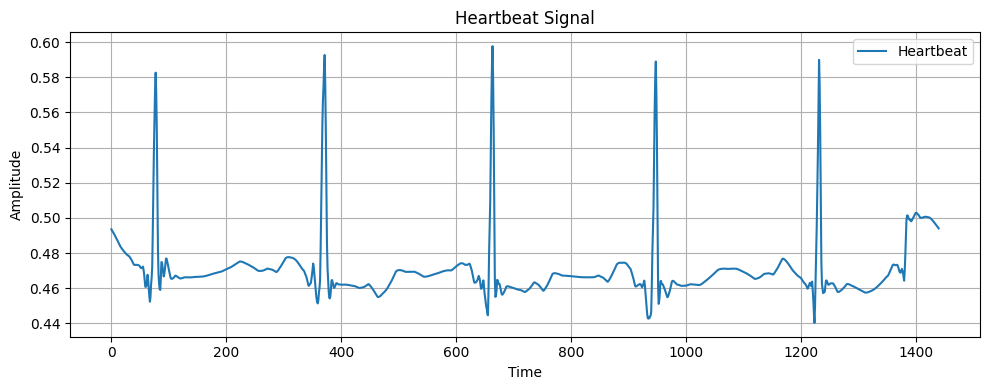

In [13]:
import matplotlib.pyplot as plt
import numpy as np

heartbeat_values = df_fusionné.iloc[4,1:]
heartbeat_values
# Creating a time axis for the 3600 points, assuming each point represents a unit of time
time_axis = np.arange(0, 1440)

# Plotting the heartbeat
plt.figure(figsize=(10, 4))
plt.plot(time_axis, heartbeat_values, label='Heartbeat')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Heartbeat Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

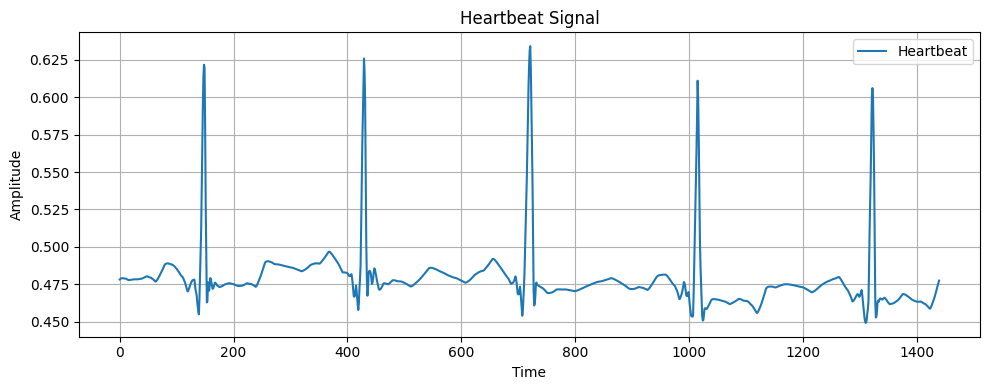

In [14]:
import matplotlib.pyplot as plt
import numpy as np

heartbeat_values = df_fusionné.iloc[3172,1:]
heartbeat_values
# Creating a time axis for the 3600 points, assuming each point represents a unit of time
time_axis = np.arange(0, 1440)

# Plotting the heartbeat
plt.figure(figsize=(10, 4))
plt.plot(time_axis, heartbeat_values, label='Heartbeat')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Heartbeat Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# df_fusionné.to_csv('df_fusionné.csv', index=False)